<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png"
         width="500" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>
            Chair of Soil Mechanics and Foundation Engineering<br>
            Geotechnical Institute<br>
            Technische Universität Bergakademie Freiberg.
        </p>
        <p>
            <a href="https://tu-freiberg.de/en/soilmechanics">
                https://tu-freiberg.de/en/soilmechanics
            </a>
        </p>
    </div>
</div>

<div style="display: flex; align-items: center;">
    <p style="margin-top: 1em;">
        To activate the <strong>interactive features</strong> when in nbviewer mode, click on &quot;Execute on Binder&quot;
        <img src="https://mybinder.org/static/favicon.ico"
             alt="Binder"
             style="height: 1.1em; vertical-align: middle; margin: 0 6px;">
        on the top right. Then, click on Run → Run All Cells.
    </p>
</div>


# Setzungen unter beliebigen Lastfiguren

Eine Möglichkeit der Berechnung von Setzungen unter beliebigen Lastfiguren ist die Superposition der Boussinesq'schen Lösung vieler Einzelkräfte, die sich zur Gesamtlastfigur aufsummieren. Grundlage dafür ist die Linearität des Modells, die Superposition / Konvolution [1] erlaubt.

[1] Nagel, T., Gerasimov, T., Remes, J., & Kern, D. (2025). Neighborhood Watch in Mechanics: Nonlocal Models and Convolution. SIAM Review, 67(1), 176–193. https://doi.org/10.1137/22M1541721

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # nötig für 3D
from concurrent.futures import ProcessPoolExecutor

In [2]:
# Parameter der Lastfläche
drand = 2. #unbelasteter Bereich
a, b = 15.0, 10.0 #Grundfläche der Last (einhüllendes Rechteck, falls kein rechteckförmiger Grundriss)
nx, ny = int(50*a/b), 50 #Gitterauflösung
dx = (a+drand) / nx
dy = (b+drand) / ny
x_centers = np.linspace(dx/2 - drand, (a+drand) - dx/2, nx)
y_centers = np.linspace(dy/2 - drand, (b+drand) - dy/2, ny)
X, Y = np.meshgrid(x_centers, y_centers)

In [3]:
# Flächenlastfunktion
# Kann auch Schichteneinteilung enthalten
def f(x, y):
        return 100 * (x / a ) * (1 - y / b) * np.heaviside(x,1) * np.heaviside(y,1) * np.heaviside(a-x,1) * np.heaviside(b-y,1)

def f(x, y):
    # Innenbereich mit maximaler Last
    a1 = 0.4 * a  # 40% von a
    b1 = 0.4 * b  # 40% von b
    x0 = a / 2
    y0 = b / 2

    # Abstand vom Mittelpunkt
    dx = np.abs(x - x0)
    dy = np.abs(y - y0)

    # Maximal erlaubte Halbausdehnung
    dx_max = a / 2
    dy_max = b / 2

    dx1 = a1 / 2
    dy1 = b1 / 2

    # Normierte Abstände (0 im Kern, 1 am Rand)
    nx = np.clip((dx - dx1) / (dx_max - dx1), 0, 1)
    ny = np.clip((dy - dy1) / (dy_max - dy1), 0, 1)

    # Last nimmt linear ab mit Entfernung von Zentrum
    load = 100 * (1 - np.maximum(nx, ny))

    # Bereich außerhalb des Rechtecks auf 0 setzen
    load *= np.heaviside(x, 1) * np.heaviside(y, 1) * np.heaviside(a - x, 1) * np.heaviside(b - y, 1)

    return load


Q = f(X, Y)

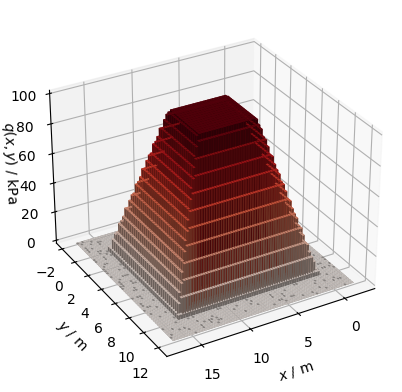

In [4]:
# Plot
from matplotlib.colors import Normalize
xpos = X.ravel()
ypos = Y.ravel()
Z = f(X, Y).ravel()
zpos = np.zeros_like(Z)  # bars start at z = 0

# Color mapping based on Z values
norm = Normalize(vmin=Z.min(), vmax=Z.max())
colors = plt.cm.Reds(norm(Z))

# Plot
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# 3D bar plot
ax.bar3d(xpos, ypos, zpos, dx, dy, Z, shade=True, color=colors)
ax.view_init(elev=30, azim=60)  # change view angle if needed

# Achsenbeschriftungcmap
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$y$ / m')
ax.set_zlabel(r'$q(x,y)$ / kPa',labelpad=-2)
fig.tight_layout();
#fig.savefig('load_pyramid.pdf')

In [12]:
# Steifemodul als Funktion der Tiefe
def E_z(z):
    return 1000 + 2000 * np.sqrt(z)

# Spannungsbeiwert nach Boussinesq (Punktlast)
def boussinesq_point(F, x_r, y_r, x_obs, y_obs, z):
    r2 = (x_obs - x_r)**2 + (y_obs - y_r)**2 + z**2
    R5 = r2**(2.5)
    return F * 3 * z**3 / (2 * np.pi * R5)

# Berechnung für einen Punkt (ix, jy)
def compute_point(ix, jy, z_layers, dz, x_centers, y_centers, Q, dx, dy):
    x_obs = x_centers[ix]
    y_obs = y_centers[jy]
    s_total = 0.0
    for z in z_layers:
        delta_sigma = 0.0
        for i in range(nx):
            for j in range(ny):
                F_ij = Q[j, i]*dx*dy
                x_r = x_centers[i]
                y_r = y_centers[j]
                delta_sigma += boussinesq_point(F_ij, x_r, y_r, x_obs, y_obs, z+dz/2) * dx * dy
        E = E_z(z)
        s_total += (delta_sigma / E) * dz
    return jy, ix, s_total

In [13]:
# Wrapper zur parallelen Berechnung
def compute_settlement_parallel(z_max=10.0, nz=40):
    z_layers = np.linspace(0, z_max, nz)
    dz = z_layers[1] - z_layers[0]
    settlement = np.zeros((ny, nx))

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_point, ix, jy, z_layers, dz, x_centers, y_centers, Q, dx, dy)
                   for jy in range(ny) for ix in range(nx)]
        for future in futures:
            jy, ix, s_val = future.result()
            settlement[jy, ix] = s_val

    return settlement

In [14]:
settlement = compute_settlement_parallel()

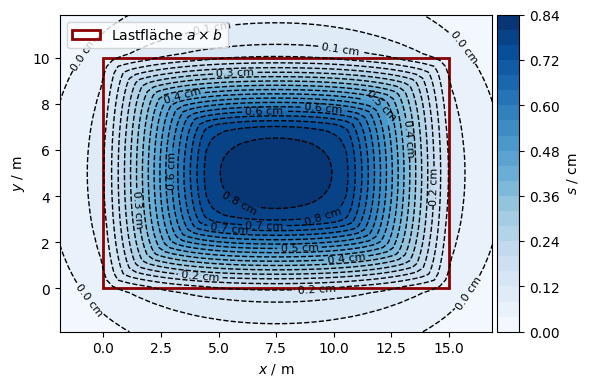

In [15]:
# Darstellung
settlement_plot = settlement*100 #m to cm
fig, ax = plt.subplots(figsize=(6, 5))
c1 = ax.contourf(X, Y, settlement_plot, levels=20, cmap='Blues')
c2 = ax.contour(X, Y, settlement_plot, levels=20, colors='black',linewidths=1,linestyles='--')
ax.clabel(c2, inline=True, fontsize=8, fmt='%1.1f cm')
rect = patches.Rectangle((0, 0), a, b, linewidth=2, edgecolor='darkred', facecolor='none',label=r'Lastfläche $a \times b$')
ax.add_patch(rect)

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
# Append a new axes to the right of ax, with fixed width and proper padding
cax = divider.append_axes("right", size="5%", pad=0.05)
# Add the colorbar to this custom axes
fig.colorbar(c1, cax=cax, label='$s$ / cm')

#ax.set_title('Oberflächensetzung mit E(z) = 10000 + 2000·√z [kPa]')
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$y$ / m')
ax.set_aspect('equal')
ax.legend(loc='upper left');
fig.tight_layout();
#fig.savefig('Setzungen.pdf')